# PROJECT DESCRIPTION
________________________
A gold mining company develops solutions for improving the operational efficiency of its industrial enterprises and needs a prototype machine learning model. The model should predict the recovery rate of gold from the ore and help the company to optimize the extraction process as to avoid launching unprofitable production. The company provided the following chart to briefly describe the currently used technology:

<br/><br/>

<img src="recovery_chart.jpg" width="500" height="600">

<br/><br/>

**Flotation.** The gold ore mixture enters the flotatation machine where it mixes with water and small amounts of reagents are added to help the separation of precious metals and selectively coat the desired particles. Then, the frothing agent is added to create thick bubbles that can hold on to these particles. A powerfull impellers spin at high speeds to create these bubbles, which swirl and rise to the top collecting the particles along the way. The resulting foam then overflows to separate and concentrate the metal bearing particles prior to the next concentrating steps. The output of the process is the rough concentrate.

**Cleaning.** The rough concentrate consequently passes two stages of cleaning, or purification, that typically include hydrometallurgy procedures involving chemical dissolution or leeching to eventually extract metals.


The company uses the following formula to calculate the recovery efficiency:

<br/><br/>

$$ Recovery = {{C \times (F-T)} \over {F \times (C-T)}} \times 100\%, $$

<br/><br/>

where C is the share of gold in the concentrate after flotation/cleaning, F - is the share of gold in the concentrate before flotation/cleaning, T - is the share of gold in the tailings

The Symmetric Mean Absolute Error (sMAPE) is expected to be used as the prediction quality metric. It considers the scale of both the target features and the predictions and is calculated as follows:

<br/><br/>

$$ sMAPE = {1\over n}
{\sum_{i = 1}^{n}{{|{y_i}-\hat{y_i}|} \times{2} \over
{|y_i|+|\hat{y_i}|}}
\times 100\%}, $$

<br/><br/>

Two recovery rates should be predicted at a time. First, the gold recovery from the raw feed (mixture), second, from the intermediate product, i.e. after the cleaning/purification stage. Based on certain engineering considerations, the final quality metric has been offered as the linear form below:

<br/><br/>

$$ Weighted \ sMAPE = 0.25 \times sMAPE(rougher) + 0.75 \times sMAPE(final) $$

<br/><br/>

# DATA DESCRIPTION
___________________

There are 3 datasets to work with:
- gold_recovery_train.csv
- gold_recovery_test.csv
- gold_recovery_full.csv

According to the company, some features may not be available in the test set and be present in the training data, as they are received with a certain time lag. The full data contains both the test and training sets with all the features. Generally, it is raw data just retrieved from the database. The following provides a gist of it:

## Technology

* Rougher feed — raw materials
* Rougher additions (or reagent additions) — flotation reagents: Xanthate (promoter, or flotation activator), Sulphate (at this project — sodium sulfide), Depressant (sodium silicate).
* Rougher process — flotation
* Rougher tails — tailings, or subproducts of recovery (occur at each stage)
* Float banks — flotation units
* Cleaner process — further cleaning/purification
* Rougher Au — rough gold concentrate
* Final Au — final gold concentrate

## Parameters at each stage

* air amount
* fluid levels
* feed size
* feed rate

## Features

[stage].[parameter_type].[parameter_name].
Example: rougher.input.feed_ag

### Possible values of [stage]:

* rougher (flotation)
* primary_cleaner
* secondary_cleaner
* final (output characteristics)

### Possible values of [parameter_type]:

* input — raw material specs
* output — product specs
* state — parameters that describe current condition at a stage
* calculation — technological/engineering calculations

# PROJECT OUTLINE
__________________
1. Data pre-procession:
    1. Open and examine the datasets.
    2. Check recovery rate calculations by findind MAE of formula (given in the project description) results and existing feature values. Draw conclusions.
    3. Examine unavailable features in the test sample.
    4. Prepare data for further research.


2. Exploratory Data Analysis:
    1. Track changes in metal concentrations (Au, Ag, Pb) from one stage to another. Draw conclusions.
    2. Compare feed size distributions within both the training and test samples. In case of significant differences, model predictions would be incorrect.
    3. Analyze total concentration of all components at all stages of recovery, i.e. in feed (raw material), primary, secondary, and final concentrate. Draw conclusions.


3. Modelling:
    1. Write a function for the final sMAPE.
    2. Train different models and cross-validate their quality. Pick the best one and check on the test sample. Draw conclusions.

# 1. DATA PRE-PROCESSING
_____________________
This part starts with the import of the necessary libraries and declaration of some global variables and then introduces the working datasets, which are checked for empty entries, irregular formats and erroneous calculations. Finally, pre-procession is carried out with brief conclusions.

## A. Downloading and Examination of Data

In [53]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

RANDOM_STATE = 9348
FLOAT_SMAPE_WEIGHT = .25
FINAL_SMAPE_WEIGHT = .75

The decision to import the above models is motivated in the "Modelling" section.

In [2]:
gold_recovery_full = pd.read_csv("gold_recovery_full.csv")
gold_recovery_full.head()
#gold_recovery_full.info()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


The main (full) dataframe is a rather bulky table consisting of 22,716 rows and 87 columns, so printing the first few objects and metadata (the line is commented out) is not that visual. This forces us to act analytically, that is pre-process data without displaying it where possible.

All the column names are in accordance with the template explained in the "Data Description" cell. With the exception of date, all the entries are floats. Unfortunately, the company has not provided units and it is unclear how the features are measured. 

Finally, all the columns, except the date, contain none types, which can potentially complicate further calculations and other operations. Although visually, their number is not critical, it is worth considering them more carefully.

In [3]:
def check_null(dataframe): 
    null_dict = dict()
    for name in list(dataframe.columns):
        null_count = dataframe[name].isna().sum()
        null_dict.update({name: null_count})
    null_stats = pd.Series(null_dict)
    return null_stats

The function above assumes a dataframe, creates an empty dict, fills it with column names as keys and missing entries count as values, and prints out short stats. Let us check how many blanks the first dataset contains.

In [4]:
check_null(gold_recovery_full).sort_values(ascending = False).head()

rougher.output.recovery               3119
rougher.output.tail_ag                2737
rougher.output.tail_sol               2736
rougher.output.tail_au                2736
rougher.input.floatbank11_xanthate    2257
dtype: int64

Indeed, there are not too many of them, nonetheless, they are mostly present in one of the target features - gold recovery rate after the flotation unit. This parameter has 3119 missing values (around 14% of the sample). Basically, only 4 variables exceed 10% share of gaps. It should be noted though that the distribution of all these gaps within the dataframe might be critical. Let us check then how many objects would be lost if all the none types are dropped in the simplest manner.

In [5]:
drop_loss = gold_recovery_full.shape[0] - gold_recovery_full.dropna().shape[0]
print(f'{drop_loss} objects, or {drop_loss * 100 / len(gold_recovery_full)}% of the sample')

6622 objects, or 29.15125902447614% of the sample


The overall data loss is estimated as about third of the sample, which is quite a lot. We shall get back to this problem later after opening the other files.

In [6]:
gold_recovery_train = pd.read_csv('gold_recovery_train.csv')
gold_recovery_train.head()
#gold_recovery_train.info()
#gold_recovery_train.shape[0] * 100 / gold_recovery_full.shape[0]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


This table is a training sample which has been withdrawn independently by the company from the full dataframe. All the previous remarks, thus, hold true about this one. The last line (commented out) says that the split was performed in 75:25 proportion. It means that the last dataset must be around 25% of the full. Consider the gaps.

In [7]:
check_null(gold_recovery_train).sort_values(ascending = False).head()

rougher.output.recovery              2573
rougher.output.tail_ag               2250
rougher.output.tail_sol              2249
rougher.output.tail_au               2249
secondary_cleaner.output.tail_sol    1986
dtype: int64

The order of the values obtained is the same as in the full dataset. However, the training sample has noticeably less blanks among the post-floatation recovery rates. Below is the last dataset.

In [8]:
gold_recovery_test = pd.read_csv('gold_recovery_test.csv')
gold_recovery_test.head()
#gold_recovery_test.info()
#gold_recovery_test.shape[0] * 100 / gold_recovery_full.shape[0]

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


For some reason, there are missing features in this table including the targets, which is strange as long as we have the full data. We are going to examine this issue closer in the corresponding subsection.

In [9]:
check_null(gold_recovery_test).sort_values(ascending = False).head()

rougher.input.floatbank11_xanthate    353
primary_cleaner.input.sulfate         302
primary_cleaner.input.depressant      284
rougher.input.floatbank10_sulfate     257
primary_cleaner.input.xanthate        166
dtype: int64

Judging by the values, none types are distributed pretty much like in the training and full data. Since this table is the smallest of the three, they are counted in hundreds.

## B. Calculations check

Let us check the validity of recovery calculations for the 'rougher.output.recovery' from the training set and try to do the same for the 'final.output.recovery'. The formula of this indicator is given in the project description and wrapped in the code below with necessary comments.

In [10]:
# c - share of gold in сoncentrate after processing.
# f - share of gold in сoncentrate/feed before processing.
# t - share of gold in tailings.

#Floatation variables.
c_float_train = gold_recovery_train['rougher.output.concentrate_au']
t_float_train = gold_recovery_train['rougher.output.tail_au']
f_float_train = gold_recovery_train['rougher.input.feed_au']

#Last unit variables (secondary cleaner).
c_final_train = gold_recovery_train['final.output.concentrate_au']
t_final_train = gold_recovery_train['final.output.tail_au']
f_final_train = gold_recovery_train['primary_cleaner.output.concentrate_au'] 

def calculate_recovery(c, t, f):
    recovery = (c * (f - t)) * 100 / (f * (c - t))
    return recovery

Now calculate mean absolute error of 'rougher.output.recovery' given in the data and formula output on the train sample.

In [11]:
float_recovery_train = calculate_recovery(c_float_train, t_float_train, f_float_train)

float_recovery_mae = ((float_recovery_train - gold_recovery_train['rougher.output.recovery'])
                      .abs().mean())
print(f'Mean absolute error of computations by formula and given values: {float_recovery_mae}')

Mean absolute error of computations by formula and given values: 1.0898633667227423e-14


MAE practically equals zero, which indicates no inconsistency in the data. It is then possible to restore later some part of missing values using this formula. Now repeat the procedure for the cleaners efficiency.

In [12]:
final_recovery_train = (calculate_recovery(c_final_train, t_final_train, f_final_train))
final_recovery_mae = ((final_recovery_train - gold_recovery_train['final.output.recovery'])
                     .abs().mean())
print(f'Mean absolute error of computations by formula and given values: {final_recovery_mae}')
#final_recovery - gold_recovery_train['final.output.recovery']

Mean absolute error of computations by formula and given values: inf


Apparently, division by zero occured in some of the terms causing the total sum to approach infinity. Most likely, f-ith equaled to zero. Whatever the reason is the calculations are false as a systematic constant-looking error is in place (print the commented line). Besides, the technological process description given by the company seems to be somewhat insufficient. This follows from the fact that the dataset contains 4 types of tailings (floatation, primary, secondary, and final) while only 3 were initially described (final is omitted). Putting other tailing type values into the formula does not change the result. This problem must be mentioned in the final report and for the time of the research we assume that all the calculations have been done corretly anyways. Clearly nan-replacement with a formula is impossible here.

## C. Examination of unavailable features

Let us now study which columns are missing in the test sample. Use the logical indexing to locate the column names in question and assign a new variable.

In [13]:
missing_cols = (gold_recovery_full.columns[~gold_recovery_full
                                           .columns.isin(gold_recovery_test.columns)])
missing_cols

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

The testing sample, as seen from the output, predominantely lacks unit output charateristics such as concentration of metals after the flotation, primary and secondary cleaning, as well as their proportion in the tailings at the same stages. Another important notion here is that the test sample does not contain target features. However, since the full dataset is at our disposal we can easily bring them back.

## D. Data pre-processing

Let us now finally solve the problems with the data discovered earlier. First, retrieve missing features from the full data and add them to the test set. But how to do that if all the indexes were reset right after the training-testing-split? The only way is to use the date column as a new index where all entries are non-null objects. Check if it is a suitable index.

In [14]:
#len(gold_recovery_full['date'].value_counts().sort_index().index) == len(gold_recovery_full)
len(gold_recovery_test['date'].value_counts().sort_index().index) == len(gold_recovery_test)

True

The number of unique date values both in the test and full datasets equals to the their respective number of rows, so the date is suitable as a new index. But what if the intersection of dates in the full dataframe and the test one does not equal to the length of the latter?

In [15]:
timestamp = (gold_recovery_full['date'].value_counts().sort_index().index
             [gold_recovery_full['date'].value_counts().sort_index().index
              .isin(gold_recovery_test['date'].value_counts().sort_index().index)])
len(timestamp) == len(gold_recovery_test)

True

Similarly to the way the missing columns were previously found, an array of dates that are specified in both datasets has been received. Its length equals the testing sample length, which means that all the data could be correctly sorted. We now replace the existing numerical index in the full dataframe with dates and perform slicing of objects corresponding to unspecified testing features.

In [16]:
missing_data = (gold_recovery_full
                .set_index(gold_recovery_full['date'])[missing_cols]
                .loc[timestamp])
missing_data.shape

(5856, 34)

Done. Now set the time index to the test data so that concatenation with the resulting dataframe (above) passes correctly. We will do the same for the training sample, which still has a numerical index.

In [17]:
# Reindexing of the test set.
gold_recovery_test = (gold_recovery_test
                      .set_index(gold_recovery_test['date'])
                      .drop(['date'], axis = 1))

In [18]:
# Reindexing of the train set.
gold_recovery_train = (gold_recovery_train
                       .set_index(gold_recovery_train['date'])
                       .drop(['date'], axis = 1))

In [19]:
# Concatenation of the test set and missing feautures.
gold_recovery_test = pd.concat([gold_recovery_test, missing_data], axis = 1)

In [20]:
# Shape check.
gold_recovery_test.shape # Minus one column (date).

(5856, 86)

All the missing columns have been restored from the original full dataframe. As soon as they were just added to the right of the table we may now rearrange them alphabetically (original order).

In [21]:
gold_recovery_test = gold_recovery_test.reindex(sorted(gold_recovery_test.columns), axis = 1)

The final task in this section is to eliminate previously identified none types. Most generally, there are four ways to do it. First, request a more complete dataset from the customer. Second, calculate, where possible, the replacement using other variables. Third, offer some artificial replacement. Fourth, just drop them all. We assume the first method is not available. The second method requires both theoretical engineering knowledge and a deep understanding of the technology that is used in this company. According to the additional information provided, it is only possible to calculate the target feature and only for the flotation output, therefore, this method can be partially resorted to. An artificial replacement could help out a lot. It is possible, for example, to find a proper theoretical distribution of features with gaps, and randomly extract replacement values from it. However, this can be performed correctly only provided that all the variables are independent but we are dealing with a process. Then the joint distributions and conditional probabilities might come in handy, but, again, it is not the best option for the same reason the second approach is not - engineering knowledge is needed. Ultimately, the most sensible and simplest way is to drop all the gaps. The remaining objects will be quite enough for training a future model, though around a third of them would be dropped. Let us first start with calculating the replacement for the target feature in the test and training sets.

In [22]:
print(f'Gaps in calculations: {float_recovery_train.isna().sum()}')
print(f'Gaps in data: {gold_recovery_train["rougher.output.recovery"].isna().sum()}')

Gaps in calculations: 2283
Gaps in data: 2573


Recovery efficiency calculated using a formula has a bit less nans than in the existing array. Add the column with formula results to the sample and get the necessary index (nans in the data AND formula values).

In [23]:
# Calculations have an old numeric index. A quick fixing. 
float_recovery_train = (float_recovery_train.reset_index()
                        .set_index(gold_recovery_train.index).drop(['index'], axis = 1))

In [24]:
# Temporary column for slicing.
gold_recovery_train['rougher.output.recovery.calc'] = float_recovery_train


# Slicing and saving the index by which the replacement is going to be done.
repl_idx_flt_trn = (
    gold_recovery_train[gold_recovery_train['rougher.output.recovery'].isna() & 
                        gold_recovery_train['rougher.output.recovery.calc'].notnull()].index)

# Replace and check.
gold_recovery_train.loc[repl_idx_flt_trn, 'rougher.output.recovery'] = (
    gold_recovery_train.loc[repl_idx_flt_trn, 'rougher.output.recovery.calc']
)
print(f'Gaps after replacement: {gold_recovery_train["rougher.output.recovery"].isna().sum()}')

Gaps after replacement: 2283


In fact, it was possible to simply replace the available data with calculations right away and get the same number of none types, but undesirable intersections might have occured. A similar procedure for the test sample:

In [25]:
# Recovery has not been calculated before on the testing set:
c_float_test = gold_recovery_test['rougher.output.concentrate_au']
t_float_test = gold_recovery_test['rougher.output.tail_au']
f_float_test = gold_recovery_test['rougher.input.feed_au']

gold_recovery_test['rougher.output.recovery.calc'] = (
    calculate_recovery(c_float_test, t_float_test, f_float_test))

# Check.
print(f'Gaps in calculations: {gold_recovery_test["rougher.output.recovery.calc"].isna().sum()}')
print(f'Gaps in data: {gold_recovery_test["rougher.output.recovery"].isna().sum()}')

Gaps in calculations: 493
Gaps in data: 546


In [26]:
# Same as before for the training data.
repl_idx_flt_tst = (
    gold_recovery_test[gold_recovery_test['rougher.output.recovery'].isna() & 
                        gold_recovery_test['rougher.output.recovery.calc'].notnull()].index)

gold_recovery_test.loc[repl_idx_flt_tst, 'rougher.output.recovery'] = (
    gold_recovery_test.loc[repl_idx_flt_tst, 'rougher.output.recovery.calc']
)
print(f'Gaps after replacement: {gold_recovery_test["rougher.output.recovery"].isna().sum()}')

Gaps after replacement: 493


All possible replacements have been done. 290 blanks are gone from the training dataset and 53 from the test one. Final step is to drop all other nans and temporary columns.

In [27]:
gold_recovery_train.drop(['rougher.output.recovery.calc'], axis = 1, inplace = True)
gold_recovery_test.drop(['rougher.output.recovery.calc'], axis = 1, inplace = True)

In [28]:
gold_recovery_train.dropna(inplace = True)
gold_recovery_test.dropna(inplace = True)

In [29]:
print(gold_recovery_train.shape)
print(gold_recovery_test.shape)

(11163, 86)
(5101, 86)


Although the data suffered a noticable loss, it is now ready for further research.

## Conclusion
__________________
In this section, we familiarized with the datasets. Two major problems have been discovered: the missing values in features and the incompleteness of the test sample. The first problem is solved by a simple nan drop, since other methods did not seem to be appropriate or justified in this project. This led to a significant loss of data (about a third of the objects), but the remaining observations are quite enough for training models. The second problem related to the lack of columns in the test sample needed for the study is solved by restoring features from the full dataset. It was concluded that the incorrect separation of the data into the training and test samples was caused not by a delay in results obtaining, but by something else, most likely, a mere technical error. In addition, the target feature calculations ('rougher.output.recovery' and 'final.output.recovery') have been checked. As far as the first one is concerned, no errors have been found, which helped to restore a total of 343 empty entries. As for the second target, it could not be checked using the existing formula, thus, further details must be obtained from the company. Also, the fourth column with tailings (at the final stage) has been discovered, which, in accordance with the initial description of the technology, remains unexplained. Probably, its the reason of its presence would clarify the calculation procedure for the 'final.output.recovery'.

# 2. EXPLORATORY DATA ANALYSIS
_______________________
This part is devoted to exploratory data analysis. The dynamics of metal concentrations throughout the recovery process is considered. The distributions of raw material granules are compared. The total content of all substances at different stages is studied for anomalies.

## A. Metal Concentrations

A grouped bar chart is seen as a good choice for visualizing changes in metal concentrations. The stages are going to be groups. In each group, bars are going to represent the average concentrations of 3 metals: gold, silver and lead. The chart is going to be printed for both datasets - training and test. For the sake of plotting conveniency, some preparation is required. Select the necessary indicators and calculate the average by the columns.

In [30]:
indicators = [
'rougher.output.concentrate_pb', 'rougher.output.concentrate_ag',
'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_pb',
'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au',
'final.output.concentrate_pb', 'final.output.concentrate_ag', 'final.output.concentrate_au', 
]

stages = ['Floatation', 'Primary', 'Secondary']
metals = ['Lead', 'Silver', 'Gold']
metal_dict = dict(zip([str(i) for i in range(len(metals) + 1)], metals))

con_data_train = gold_recovery_train[indicators].mean(axis = 0)
con_data_test = gold_recovery_test[indicators].mean(axis = 0)

In the cell above, all the necessary information is saved in lists and a dictionary to facilitate reference while plotting. The last two lines calculate the means by all columns from the first list. Next, prepare a multi-index for these means and join 2 series objects.

In [31]:
multidx = pd.MultiIndex.from_product([stages, metals], names = ['Stage', 'Metal'])

In [32]:
bar_chart_data_train = pd.Series(data = con_data_train.values, index = multidx)
bar_chart_data_test = pd.Series(data = con_data_test.values, index = multidx)
bar_chart_data_train
#bar_chart_data_test

Stage       Metal 
Floatation  Lead       7.532421
            Silver    11.717793
            Gold      19.564896
Primary     Lead       9.568583
            Silver     8.435391
            Gold      32.316159
Secondary   Lead      10.163855
            Silver     5.155674
            Gold      44.115810
dtype: float64

This is how one-dimensional arrays with average metal concentrations per stage look like as a multi-indexed serie. Now, plot the charts.

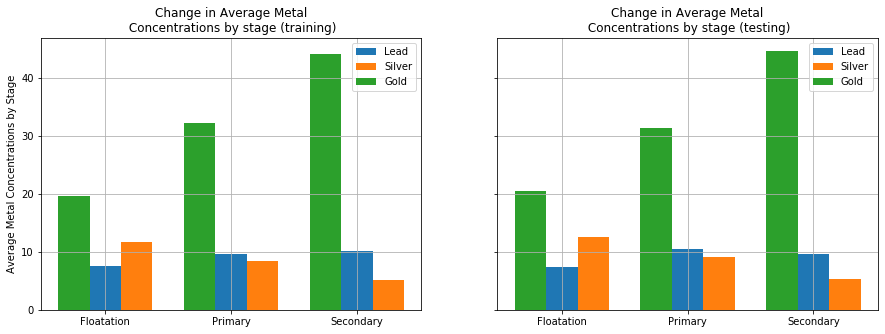

In [33]:
x = np.arange(len(stages))
width = 0.25

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 5), sharey = True)

for k in range(len(stages)):
    rects_train = (ax1.bar(x + width * int(np.ceil((k / 2) * (-1) ** ((k + 1)))),
                           bar_chart_data_train.xs(metal_dict[str(k)], level = 1),
                           width, label = metal_dict[str(k)]))
for l in range(len(stages)):
    rects_test = (ax2.bar(x + width * int(np.ceil((l / 2) * (-1) ** ((l + 1)))),
                          bar_chart_data_test.xs(metal_dict[str(l)], level = 1),
                          width, label = metal_dict[str(l)]))

ax1.set_ylabel('Average Metal Concentrations by Stage')
ax1.set_title('Change in Average Metal\n Concentrations by stage (training)')
ax1.set_xticks(x)
ax1.set_xticklabels(stages)
ax1.grid()
ax1.legend();

ax2.set_title('Change in Average Metal\n Concentrations by stage (testing)')
ax2.set_xticks(x)
ax2.set_xticklabels(stages)
ax2.grid()
ax2.legend();

Since the units of parameters have not been provided, we think of the concentration values as some arbitrary units, although, judging by the numbers, they are indicated as a percentage of the product. Due to the fact that apart from metals the product contains other components, the sum of these values does not add up to 100%.

Naturally, gold has the highest concentration at all stages of the technological process; otherwise, some other ore should have been fed as a raw material. As the ore goes through the flotation and both stages of cleaning, the concentration of gold increases (flotation: approx. 20, primary: 32, secondary: 44), which indicates that the technology works normally. Clearly, the gold concentration grows linearly. On the contrary, silver is sequentially removed from the product (flotation: approx. 12, primary: 8, secondary: 5), which means that its content in the tailings should grow. At the same time, there is a noticeable increase in the proportion of copper from the flotation unit to the secondary cleaner: 7.5, 9.5 and 10. The copper, whether intentionally or not, is not separated from the product. Why - a question to process engineers. A non-professional assumption is that lead removal requires more complex procedures, since its atomic mass is much closer to the atomic mass of gold, rather than silver. The latter is the lightest metal of the three.

The adjacent chart plotted on the test data has been added for reassurance. The trends clearly coincide, with the exception of lead, the concentration of which after the last stage turned out to be slightly lower than before. Most likely, such a difference was obtained by chance. The values in both diagrams are also approximately the same. For this purpose, the y-axis has been set shared.

## B. Raw Material Grain Size

Now study the grain size distribution in the feed. If the distribution in the test sample differs markedly from its training set counterpart, the model will not be able to effectively predict the target features. Let us use histograms for the demonstration. As soon as these graphs are plotted once during the study, on this occasion the DRY principle is going to be violated.

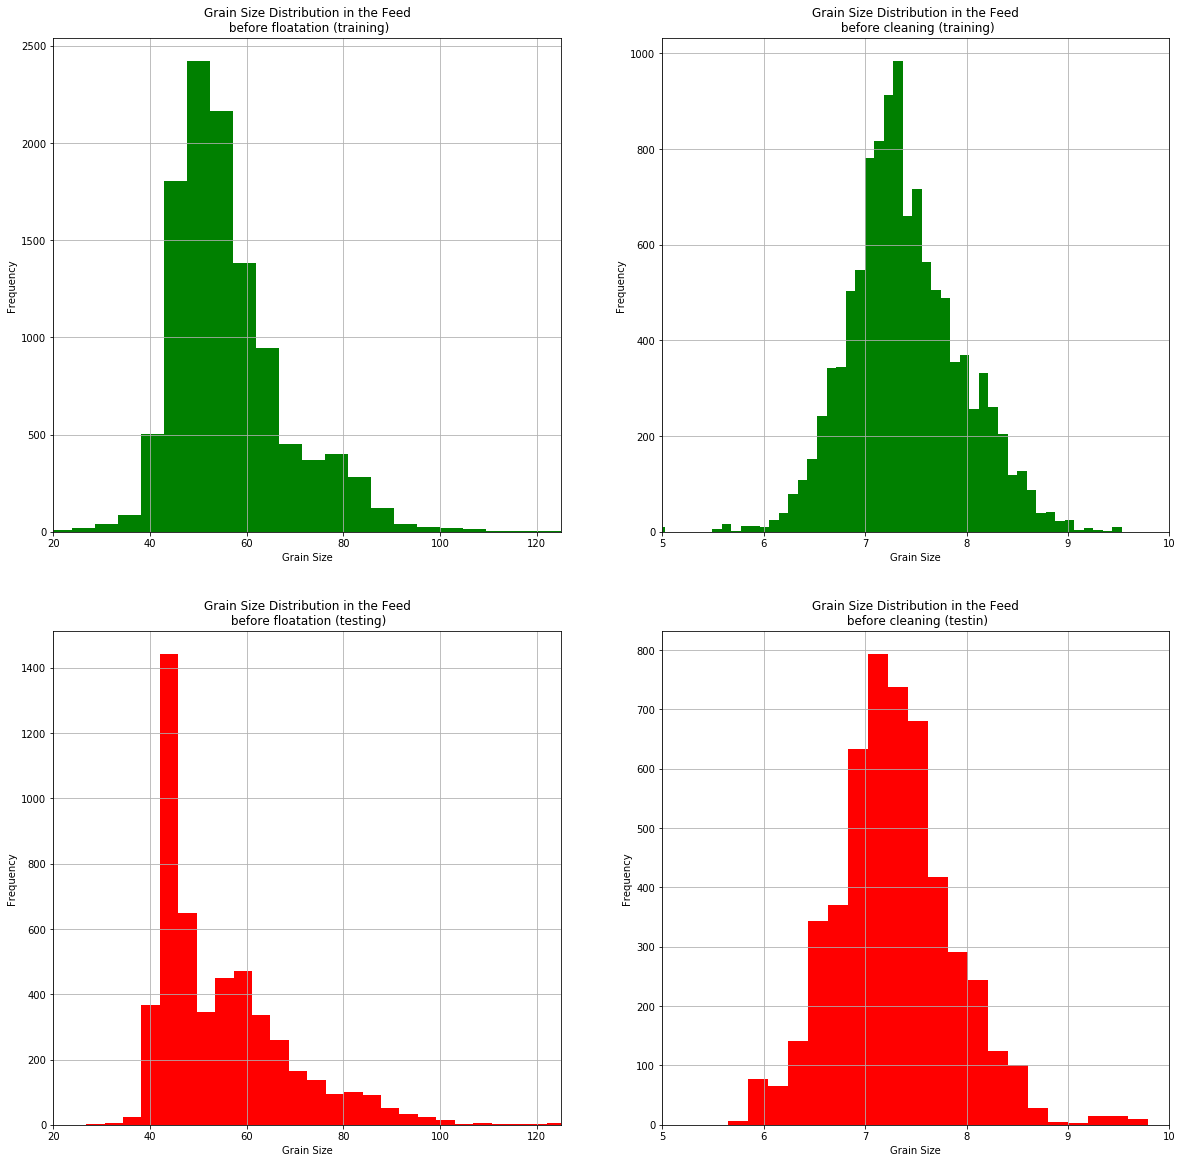

In [34]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 20))

x1 = gold_recovery_train['rougher.input.feed_size'] 
x2 = gold_recovery_train['primary_cleaner.input.feed_size']
x3 = gold_recovery_test['rougher.input.feed_size']
x4 = gold_recovery_test['primary_cleaner.input.feed_size']

axs[0, 0].hist(x1, bins = 100, color = 'g');
axs[0, 0].grid()
axs[0, 0].set_title('Grain Size Distribution in the Feed\n before floatation (training)')
axs[0, 0].set_xlabel('Grain Size')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_xlim(20, 125); # Comment this line to see outliers.

axs[0, 1].hist(x2, bins = 100, color = 'g');
axs[0, 1].grid()
axs[0, 1].set_title('Grain Size Distribution in the Feed\n before cleaning (training)')
axs[0, 1].set_xlabel('Grain Size')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_xlim(5, 10); # Comment this line to see outliers.

axs[1, 0].hist(x3, bins = 50, color = 'r');
axs[1, 0].grid()
axs[1, 0].set_title('Grain Size Distribution in the Feed\n before floatation (testing)')
axs[1, 0].set_xlabel('Grain Size')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_xlim(20, 125); # Comment this line to see outliers.

axs[1, 1].hist(x4, bins = 50, color = 'r');
axs[1, 1].grid()
axs[1, 1].set_title('Grain Size Distribution in the Feed\n before cleaning (testin)')
axs[1, 1].set_xlabel('Grain Size')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_xlim(5, 10); # Comment this line to see outliers.

It should be noted that there are only 2 features representing the feed size: before the flotation unit and the primary cleaner. Probably, intermediate measurements are difficult during the cleaning process, therefore, primary and secondary cleaning is considered a single unit. With this assumption, the histogram titles on the right side do not indicate a distinction. Again, like before, we consider the size to be in arbitrary units. Most likely, it is the maximum measurement of a granule in mm., for instance. It is a conventional approach of measuring, say, garbage coming to a wastewater treatment plant.

The first row of the histograms (green) corresponds to the feed size distributions within the training sample at the flotaton and cleaning stages, while the second (red) illustrates the same on the test data. Such an arrangement shows that the distribution shapes across samples are more or less identical. Natural (due to the sample size) distortions can be detected, for example, in the lower left histogram.

On average, the grain size before the flotation is about 40 - 60, and changes to 7 - 8 afterwards. The flotator significantly homogenizes the incoming ore with subsequent serious reduction in variance. Also, each feature has outlier values, which should be get rid of in order to train models effectively. These outliers could be seen if all the lines ax[\*].set_xlim(\*) are commented out. Limitations are set visually. Beside outliers, there are also zero values. They are especially noticeable in the test sample (for flotation). Zeros mean nothing came into the flotator, then nothing should have come out. Even medieval alchemists needed something to get gold from. The same applies to primary cleaning. Zeros, thus, must be eliminated. Now let us look at how many objects the datasets would loose if the outliers and zeros defined in this way are dropped.

In [35]:
recovery_train = (gold_recovery_train[
    (gold_recovery_train['rougher.input.feed_size'] > 20) &
    (gold_recovery_train['rougher.input.feed_size'] <= 125) &
    (gold_recovery_train['primary_cleaner.input.feed_size'] > 5) &
    (gold_recovery_train['primary_cleaner.input.feed_size'] <= 10)
])

recovery_test = (gold_recovery_test[
    (gold_recovery_test['rougher.input.feed_size'] > 20) &
    (gold_recovery_test['rougher.input.feed_size'] <= 125) &
    (gold_recovery_test['primary_cleaner.input.feed_size'] > 5) &
    (gold_recovery_test['primary_cleaner.input.feed_size'] <= 10)
])

train_loss = len(gold_recovery_train) - len(recovery_train)
test_loss = len(gold_recovery_test) - len(recovery_test)

print(f'Loss in the training set: {train_loss}')
print(f'Loss in the testing set: {test_loss}')

Loss in the training set: 82
Loss in the testing set: 25


Such losses are acceptable. An alternative well-known approach to eliminating anomalies involves cutting off all the values that lie beyond 1.5 interquartile range, but that does not seem a good option in this case. The data loss would be much more serious: 9208 objects would remain in the training set, and 4400 in the test (calculations omitted). That is due to the dependency of both variables and different distributions. Thus, the “visual” approach seems to be an appropriate trade-off.

## C. Total Concentrations

Finally in this section, we study the total concentrations of substances at all stages of the process. These include copper, gold, silver and various impurities. Flotation reagents, such as xanthate, sodium sulfide and sodium silicate, will not be taken into account, since in the general case they temporarily remain within the unit and can even be separately removed from the system. The purpose of this analysis is to identify anomalies in the dataset, the presence of which may affect predictions of a future model. We will search for outliers by plotting boxplots, as they clearly demonstrate such values. Let us create a list of all the columns containing the necessary arrays.

In [36]:
full_con_list = [
    'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol',
    'rougher.input.feed_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol', 'rougher.output.concentrate_au',
    'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb',
    'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au',
    'final.output.concentrate_ag', 'final.output.concentrate_pb',
    'final.output.concentrate_sol', 'final.output.concentrate_au'
]

There are multiple graphs to be plotted, so this process is subject to automation.

In [37]:
def box_plotter(array1, array2, title, ylabel, notch = True, labels = None,
                showmeans = True, meanline = True):
    
    fig, axes = plt.subplots(figsize=(15, 7))

    bplot = axes.boxplot([array1, array2], notch = notch, labels = labels,
                         showmeans = showmeans, meanline = meanline)

    axes.set_title(title)
    axes.set_ylabel(ylabel)
    axes.grid()

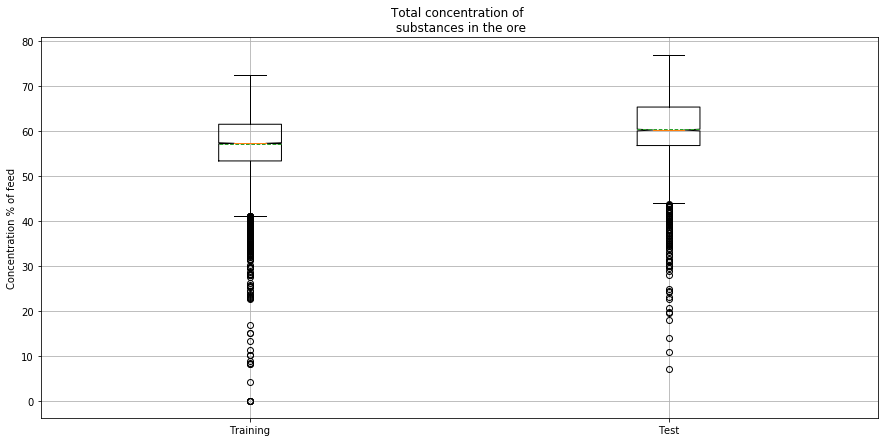

In [38]:
box_plotter(recovery_train[full_con_list[0:4]].sum(axis = 1),
           recovery_test[full_con_list[0:4]].sum(axis = 1),
           'Total concentration of \n substances in the ore', 'Concentration % of feed',
           labels = ['Training', 'Test'])

We see the distribution of the concentration of metals and other impurities in the flotator feed. The whiskers length in each sample is approximately the same, as is the size of the boxes. The average is about 57-60% (the data hints it is denoted as a percentage) and is equal to the median. Both samples seem to be normally distributed. The only thing that is a bit strange is a certain number of zero values. They can be painlessly eliminated, although it not compulsory. Something got into the system, but contained neither impurities nor metals. Just something else. We do not have complete information here, so it is difficult to reason.

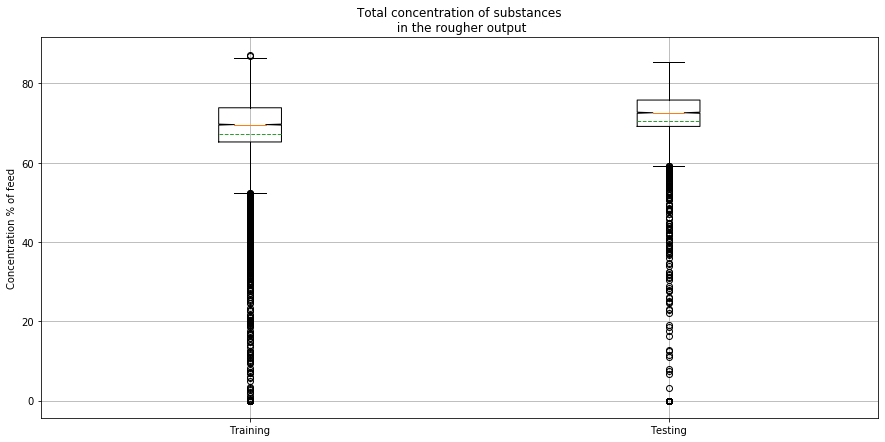

In [39]:
box_plotter(recovery_train[full_con_list[4:8]].sum(axis = 1),
           recovery_test[full_con_list[4:8]].sum(axis = 1),
           'Total concentration of substances\n in the rougher output',
            'Concentration % of feed', labels = ['Training', 'Testing'])

The concentration increases as it passes the flotation. On this plot, it averages around 70-75%. The interquartile range on the training sample is slightly wider than on the testing one, while the whiskers are slightly longer. Asymmetry is in place: there are a heavy tails on the left, which in both datasets pull the average off the median. Sometimes the rough concentrate does not contain any of these substances, just as it happens at the entrance to the unit.

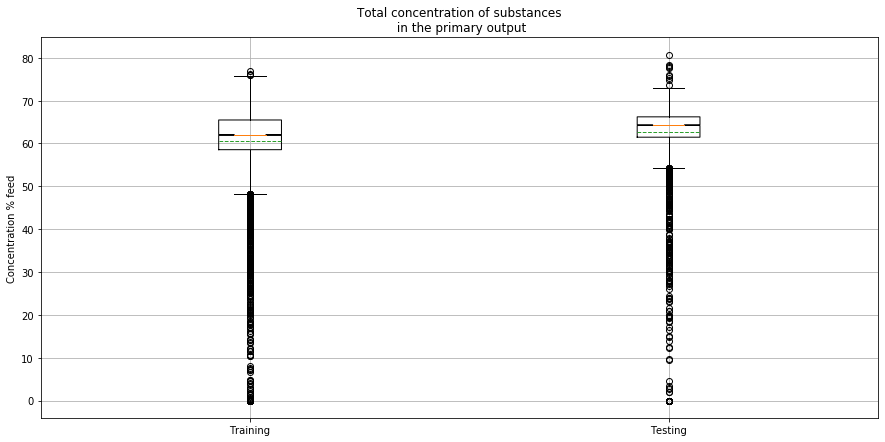

In [40]:
box_plotter(recovery_train[full_con_list[8:12]].sum(axis = 1),
            recovery_test[full_con_list[8:12]].sum(axis = 1),
            'Total concentration of substances\n in the primary output',
            'Concentration % feed', labels = ['Training', 'Testing'])

After the primary cleaning, the total concentration of substances in the product does not seem to change in its distribution shape: just as before, the mean deviates slightly from the median towards zero due to heavy tails on the left. Variance in both arrays gets reduced. On the whole, all that has been said about the rougher concentrate holds here, except one point. For some reason, after a finer processing, the total concentration noticeably decreases on average reaching around 63-65%. We assume that we are not well aware of some of the technological nuances. Perhaps, it is more convenient to extract certain amount of gold from the tailings. Anyways, this fact is worth mentioning in the final report.

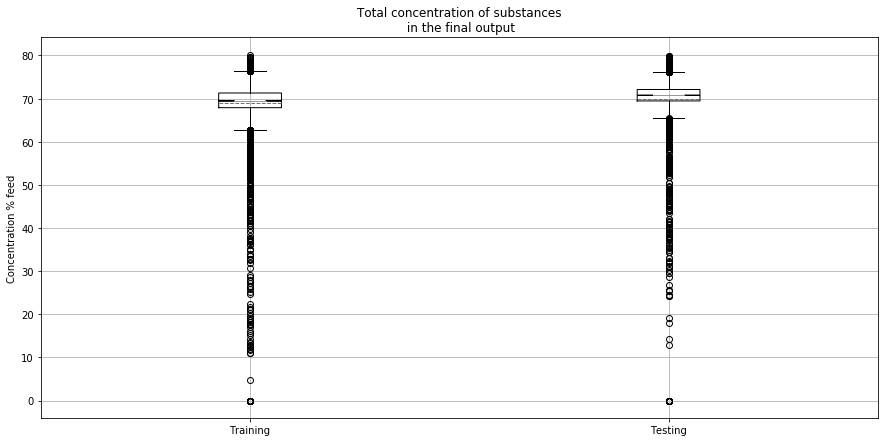

In [41]:
box_plotter(recovery_train[full_con_list[12:16]].sum(axis = 1),
            recovery_test[full_con_list[12:16]].sum(axis = 1),
            'Total concentration of substances\n in the final output',
            'Concentration % feed', labels = ['Training', 'Testing'])

The final concentrate has the least variability across all stages. The whiskers in both cases are short and the boxes are narrow. As before, there is a large number of small values, including zeros. The mean grouped around 70-72%. Everything seems natural. Except one point.

At all the stages, the test sample means turned out to be higher than in the training. Truly, the training set is much larger and these results may be obtained by chance, but it happens systematically. This leads to suspicions that the test sample was fundamentally poorly selected for research. Such suspicions, in turn, forces a statistical test. Let us check the equal means hypothesis for each stage. We are going to use the one-tail t-test. It does not require the samples to be the same size. Let confidence probability be equal to 0.05. Additionally, we can assume equal variances, which is generally confirmed by the look of boxplots. For faster results t-testing is looped.

In [42]:
for i in range(0, 16, 4):
    alpha = .05
    results = st.ttest_ind(recovery_train[full_con_list[i: i + 4]].sum(axis = 1),
                           recovery_test[full_con_list[i: i + 4]].sum(axis = 1),
                           equal_var = True)
    print('p-value:', results.pvalue / 2)
    if (results.pvalue / 2 < alpha) and (
        recovery_train[full_con_list[0:4]].sum(axis = 1).mean() <
        recovery_test[full_con_list[0:4]].sum(axis = 1).mean()):
        print("Reject Null Hypothesis")
    else:
        print("Null Hypothesis cannot be rejected")

p-value: 2.3576542048138845e-205
Reject Null Hypothesis
p-value: 5.9534222946909e-51
Reject Null Hypothesis
p-value: 6.602664456731433e-39
Reject Null Hypothesis
p-value: 7.767017177885635e-22
Reject Null Hypothesis


The probability of getting differences in mean concentrations of all substances in the feed is 2 to the power of -205! Well, it gradually increases up to 7.7 to the power of -22 in the final product but, obviously, this is a problem and it must be solved, otherwise further research does not make sense yet. We can make several assumptions about why such results are obtained. Firstly, relocation to a new site, where the composition of the ore is qualitatively different. Secondly, as time passes, i.e. extraction continues, the ore composition may naturally change. Thirdly, the least probable scenario, the recovery technology could have been modified in some way. Still it seems the matter is simply with the input material. Let us try to compare the dates of the observations.

In [43]:
first_record_train = pd.to_datetime(recovery_train.reset_index()['date']).min()
last_record_train = pd.to_datetime(recovery_train.reset_index()['date']).max()
first_record_test = pd.to_datetime(recovery_test.reset_index()['date']).min()
last_record_test = pd.to_datetime(recovery_test.reset_index()['date']).max()
print(f'Observations in the training set date from {first_record_train} to {last_record_train}')
print(f'Observations in the test set date from {first_record_test} to {last_record_test}')

Observations in the training set date from 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Observations in the test set date from 2016-09-01 00:59:59 to 2017-12-31 23:59:59


The test set dates are a subset of the training set dates. The observations in the latter set were collected over 2 years and 7 months and over 1 year and 3 months in the former, which is as twice as a shorter period. It is very doubtful that the test has been compiled randomly. Irrespectively of the actual reason the only what is left to do is to merge the samples and randomly resplit it in the initial proportion. In the meantime, the balance of objects that has been slightly disturbed during the pre-procession would be recovered.

In [44]:
full_gold_data = (pd.concat([recovery_train, recovery_test])
                  .sample(frac = 1, random_state = RANDOM_STATE))

In [45]:
train, test = train_test_split(full_gold_data, test_size = .25, random_state = RANDOM_STATE)

# Check split proportion:
#print(train.shape[0] / len(full_gold_data))
#print(test.shape[0] / len(full_gold_data))

## Conclusion
__________________
Within the distributions themselves, no anomalies in the total concentration of substances at all stages in both samples have been detected. There is a number of 0% values, but this can hardly be considered an anomaly. It might happen under the assumption that the product contains some type of impurities other than denoted by "feed_sol" feature, which is the case. The sum of all concentrations and tailings is close, but not equal to 100% (checking this fact is offered to the reader). At the same time, a drop in this value at the cleaning stage with its subsequent increase in the output seems somewhat strange. This point should be clarified by the company process engineers.

A global anomaly was revealed when comparing all distributions in both samples with one another. At all stages, the average for the test sample was significantly higher than for the training one. Subsequent statistical testing confirmed that it is practically impossible to obtain such differences by chance, thus, the test sample was poorly selected. The dates of the observations also speak in favor of this. Finally, due to the inability to request a company’s comment on this issue, it was decided to merge both datasets into one, shuffle it and randomly split again in the original proportion.

# 3. MODELLING
_______________________
This section is devoted to choosing the features for the training, defining a quality metric function, choosing suitable models, cross-validating their predictions, picking the best model, and, finally, testing it on the corresponding sample.

There are two target features to be predicted: 'rougher.output.recovery' (efficiency of gold ore mixture recovery) and 'final.output.recovery' (efficiency of the intermediate concentrate recovery). To this end, it seems reasonable to divide all the features in both samples into those that belong to the first and second target feature, and then train two models on these divisions. The company expects weighted sMAPE metric (see the project description) to be minimized. Let us decide how to divide the features.

First off, an obvious choice is the variables from the recovery calculation formula. They have been studied in the previous section. The concentrations of other metals and impurities could also be included in the training features. As reagents, liquid levels, and air volume within the flotation unit affect the recovery process, they must also serve as estimators for the model. Since engineering calculations are not empirical data, they should be discarded. All other output concentrations, including tailings (except those containing gold), would be redundant.

As far as the second target feature is concerned, a set of variables corresponding to the subsequent process stages should estimate it. This includes the product characteristics at the entrance to the primary cleaner (other metals and substances) and excludes intermediate and final tailings and concentrations that are not related to gold. System parameters and additional chemical components will also be involved in the training. Using the lists, we explicitly indicate which columns are going be used to avoid mistakes and make the choice transparent.

In [46]:
float_params = ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate',
'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au',
'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate',
'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate',
'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_au',
'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level',
'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level',
'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level',
'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level']

In [47]:
final_params = ['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_au',
'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level',
'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level',
'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level',
'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level', 
'secondary_cleaner.output.tail_au', 'secondary_cleaner.state.floatbank2_a_air',
'secondary_cleaner.state.floatbank2_a_level', 'secondary_cleaner.state.floatbank2_b_air',
'secondary_cleaner.state.floatbank2_b_level', 'secondary_cleaner.state.floatbank3_a_air', 
'secondary_cleaner.state.floatbank3_a_level', 'secondary_cleaner.state.floatbank3_b_air',
'secondary_cleaner.state.floatbank3_b_level', 'secondary_cleaner.state.floatbank4_a_air',
'secondary_cleaner.state.floatbank4_a_level', 'secondary_cleaner.state.floatbank4_b_air',
'secondary_cleaner.state.floatbank4_b_level', 'secondary_cleaner.state.floatbank5_a_air',
'secondary_cleaner.state.floatbank5_a_level', 'secondary_cleaner.state.floatbank5_b_air',
'secondary_cleaner.state.floatbank5_b_level', 'secondary_cleaner.state.floatbank6_a_air',
'secondary_cleaner.state.floatbank6_a_level', 'final.output.concentrate_au', 
'final.output.recovery', 'final.output.tail_au']

Surely, not the prettiest code, but easy to follow.

In [48]:
X_train_float = train[float_params].copy().drop(['rougher.output.recovery'], axis = 1)
X_train_final = train[final_params].copy().drop(['final.output.recovery'], axis = 1)
X_test_float = test[float_params].copy().drop(['rougher.output.recovery'], axis = 1)
X_test_final = test[final_params].copy().drop(['final.output.recovery'], axis = 1)

y_train_float = train['rougher.output.recovery'].copy()
y_train_final = train['final.output.recovery'].copy()
y_test_float = test['rougher.output.recovery'].copy()
y_test_final = test['final.output.recovery'].copy()

All the features in the datasets are real numbers, including the target ones, therefore, the regression problem is being solved - relevant regression models should be considered. The number of objects in the data does not exceed 100,000 and they are represented by a fairly large number of parameters. For this reason, the linear regression and the support vector machine (namely, its linear and radial-basis version) are proposed as the candidate models (see imports in the first code cell). The random forest could also be good option, however, due to the given conditions of the problem, this model is not suitable. In the sklearn library, the default quality metric for this algorithm is MSE and setting a custom function (sMAPE in our case), unfortunately, is not yet supported.

The training features are grouped and the models selected. Now, define the function for the prediction quality (sMAPE metric).

In [60]:
def sMAPE(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    abs_error = np.abs(y_true - y_pred)
    abs_mean = (np.abs(y_true) + np.abs(y_pred)) / 2
    sum_terms = (abs_error / abs_mean)
    sMAPE = np.mean(sum_terms) * 100
    return sMAPE


def weighted_sMAPE(smape1, smape2, w1 = FLOAT_SMAPE_WEIGHT, w2 = FINAL_SMAPE_WEIGHT):
    result = (w1 * smape1) + (w2 * smape2)
    return result

The cross-validation requires converting the above function to the sklearn object to use it as a custom scoring method. We are going to do this with the "make_scorer" tool. It has the "greater_is_better" parameter, which should be set to false. As long as the metric itself is an error estimator, all of its values have to be negated to solve the minimization problem. This is exactly what this parameter does.

In [50]:
sMAPE_error = make_scorer(sMAPE, greater_is_better = False)

Since the sample values all have different scale, they are subject to the normalization. Although the random forest predictions would not be significantly improved, for other selected models normalization is strongly recommended.

In [51]:
scaler_float = StandardScaler().fit(X_train_float)
X_train_float_scaled = scaler_float.transform(X_train_float)
X_test_float_scaled = scaler_float.transform(X_test_float)

scaler_final = StandardScaler().fit(X_train_final)
X_train_final_scaled = scaler_final.transform(X_train_final)
X_test_final_scaled = scaler_final.transform(X_test_final)

Now cross-validate the prediction quality (sMAPE) of the models. Let the k-folds be equal to 5, so that the calculations do not take much time. The results are going to be packed into a table.

In [54]:
warnings.filterwarnings("ignore", category = FutureWarning)

quality_float = list()
quality_final = list()
for model in [LinearRegression(), SVR(kernel = 'linear'), SVR()]:
    error_float = cross_val_score(model, X_train_float_scaled, y_train_float, scoring = sMAPE_error, cv = 5)
    quality_float.append(error_float)
    error_final = cross_val_score(model, X_train_final_scaled, y_train_final, scoring = sMAPE_error, cv = 5)
    quality_final.append(error_final)

In [55]:
cv_float_results = pd.DataFrame(data = {'Linear Regression': quality_float[0], 'SVR (linear)': quality_float[1],
                                        'SVR (rbf)': quality_float[2]})
cv_final_results = pd.DataFrame(data = {'Linear Regression': quality_final[0], 'SVR (linear)': quality_final[1],
                                        'SVR (rbf)': quality_final[2]})
cv_float_results

,Linear Regression,SVR (linear),SVR (rbf)
0,-9.905576,-6.062110,-5.438265
1,-8.850211,-5.141286,-4.537203
2,-9.886403,-6.652043,-6.106692
3,-10.309460,-6.656192,-6.149035
4,-8.929066,-6.122697,-5.540479


In [56]:
cv_float_results.mean(axis = 0)

Linear Regression   -9.576143
SVR (linear)        -6.126866
SVR (rbf)           -5.554335
dtype: float64

The dataframe index represents the number of a validation subsample (fold). Clearly, the SVR with rbf-kernel provides the best predictions of the gold recovery efficiency at the flotation stage. On average the quality metric on 5 validation folds was just over 5.5% (remember the make_scorer artificially negates the results). sMAPE of the linear regression and SVR resulted in 9.6 and 6.12% respectively.

In [57]:
cv_final_results

,Linear Regression,SVR (linear),SVR (rbf)
0,-6.169324,-5.865063,-4.687624
1,-6.381671,-5.972672,-4.922879
2,-6.061332,-5.801414,-4.732481
3,-6.811580,-6.560991,-5.610785
4,-6.502391,-6.135961,-5.227723


In [58]:
cv_final_results.mean(axis = 0)

Linear Regression   -6.385260
SVR (linear)        -6.067220
SVR (rbf)           -5.036298
dtype: float64

sMAPE of the final stage recovery predictions (at the exit from the system) has arranged in a similar order. Again, the radial basis SVR has demonstrated the best performance of 5%. Its linear version showed 6%, while a simple linear regression is even 0.3% worse. So, the radial basis kernel SVR is the best choice for a prototype model. Now fit 2 of its instances on the entire training data, test and weigh the metrics.

In [61]:
svr_float = SVR().fit(X_train_float_scaled, y_train_float)
svr_final = SVR().fit(X_train_final_scaled, y_train_final)

predicted_float = svr_float.predict(X_test_float_scaled)
predicted_final = svr_final.predict(X_test_final_scaled)

# Weights have been declared as global variables in the import cell.
weighted_metric = weighted_sMAPE(sMAPE(y_test_float, predicted_float), sMAPE(y_test_final, predicted_final))

print(f'Weighted sMAPE of SVR (rbf) is {round(weighted_metric, 2)}%')

Weighted sMAPE of SVR (rbf) is 5.05%


Quite a good result for a prototype model has been obtained. Its symmetric mean absolute percentage error is 5%. It is now up to the company to decide whether it is a lot or a little, because it possesses all necessary business metrics for evaluation. The final step is a quick sanity-check. Let us look at how much better the fit model predicts the target than a simple averaging.

In [62]:
mean_preds_float = np.full((len(y_test_float), 1), y_test_float.mean())
mean_preds_final = np.full((len(y_test_final), 1), y_test_final.mean())

comparision = weighted_sMAPE(sMAPE(y_test_float, mean_preds_float), sMAPE(y_test_final, mean_preds_final))
print(f'Weighted sMAPE of averaging is {round(comparision, 2)}%')

Weighted sMAPE of averaging is 9.6%


The final model is sane, since the averaging model is as twice as worse in predicting the target values showing 9.6%.

## Conclusion
________________
The training and test sample was divided into two parts: features estimating the flotation recovery of ore mixture and cleaning (both primary and secondary) recovery. Redundant parameters, such as engineering calculations and intermediate concentrations of non-gold related substances, were droped. Then, the function for quality metric (sMAPE) calculation was defined. Cross-validation with 5 folds for each target feature was carried out for the most suitable models: linear regression and two types of SVR. According to the results, the SVR model with a radial basis kernel function turned out to be the best in predicting both targets. Further fitting it on all the training data and testing showed that a weighted quality metric was 5%.

# FINAL CONCLUSION
___________________________

## BUG-REPORT

Examination of the datasets provided by the company revealed several problems. First, the data contained a rather large number of empty entries. Their elimination led to the loss of about a third of the training objects. Second, the test sample was incomplete: it lacked output parameters of the process units. Since there was an indication that the full dataset contained all the necessary data, the missing columns were restored by the dates of observation. As no error occured, all indicators had been, in fact, received on time. Thirdly, exploratory and statistical analysis revealed that the test sample had been poorly selected in the first place in violation of the randomness principle. This is evidenced by cross-stage distributions of the total concentration of all substances. The means in the test sample were significantly higher than in the training one. The probability of obtaining such differences by chance at a 5% significance level tends to zero. The timestamps showed that the period of observation in the test data does not correspond to the period in the training. These facts, as well as the inability to explain the nature of the detected anomaly, left no option but to randomly resplit the data into a training and test sample. Fourth, no units for features have been provided by the company in the data description, which caused some confusion and prevented a more accurate interpretation of the results. This also included the incompleteness in the technological process description, therefore, it was not possible to explain the additional tailings (final) column. Also, it was unclear why the concentration of lead in the product increased during recovery (is it even removed?) and impossible to calculate the gold recovery for the final stage using the formula. Fifth, zero values were found in the feed size column.

## RESEARCH RESULTS

The pre-processed data in the training and test sample was divided in relation to the target features ('rougher.output.recovery' and 'final.output.recovery') into two subsamples. The estimators for each of the targets included recovery formula terms and the parameters characterizing the process state. Such an approach could be useful in the future for process engineers to determine implicit dependencies. Linear regression and SVR models (also linear and radial basis) were selected as the prototype candidates. Cross-validation of the sMAPE metric showed that the best of them was the SVR model with a radial basis kernel. On average across 5 folds, the error of its predictions for the flotation efficiency amounted 5.5%, whereas for cleaning unit it reached 5%. The final weighted metric (weights: 0.25 and 0.75) on the test data was 5%, which, apparently, is a good result for the prototype. However, only the company can realistically evaluate it once took business metrics into consideration. In conclusion, it should be stated that the resolution of the problems mentioned in the bug report can allow to adjust the approach to building the model and, as a result, substantially improving the prototype's quality.